<a href="https://colab.research.google.com/github/helenpiepie/hl.github.io/blob/master/Food_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Recommendation: Clustering Models

Image we are a company who designs food menu for **Hyperglycemic patients**. One of our services is to help patients prevent or **reduce the intake of high-carbohydrate and high-fat food**. In this notebook, 45027 kinds of food are listed and clustered as either 'healthy' or 'unhealthy' food.

## Ingest

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
sns.set(style="white", palette="muted", color_codes=True)


In [0]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/noahgift/food/master/data/features.en.openfoodfacts.org.products.csv")
df.drop(["Unnamed: 0", "exceeded", "g_sum", "energy_100g"], axis=1, inplace=True) #drop two rows we don't need
df = df.drop(df.index[[1,11877]]) #drop outlier
df.rename(index=str, columns={"reconstructed_energy": "energy_100g"}, inplace=True)
df.head()

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,product
0,28.57,64.29,14.29,3.57,0.00000,2267.85,Banana Chips Sweetened (Whole)
2,57.14,17.86,3.57,17.86,1.22428,2835.70,Organic Salted Nut Mix
3,18.75,57.81,15.62,14.06,0.13970,1953.04,Organic Muesli
4,36.67,36.67,3.33,16.67,1.60782,2336.91,Zen Party Mix
5,18.18,60.00,21.82,14.55,0.02286,1976.37,Cinnamon Nut Granola


## EDA

In [0]:
df.columns

Index(['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
       'salt_100g', 'energy_100g', 'product'],
      dtype='object')

In [0]:
df.shape

(45026, 7)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45026 entries, 0 to 45027
Data columns (total 7 columns):
fat_100g              45026 non-null float64
carbohydrates_100g    45026 non-null float64
sugars_100g           45026 non-null float64
proteins_100g         45026 non-null float64
salt_100g             45026 non-null float64
energy_100g           45026 non-null float64
product               44976 non-null object
dtypes: float64(6), object(1)
memory usage: 2.7+ MB


### Sort by Sugar, Carbohydrate, Fat

In [0]:
df.sort_values(by=["sugars_100g","carbohydrates_100g","fat_100g"], ascending=[True, True, True]).head(10)

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,product
7612,0.0,3.61,-1.2,2.41,0.38354,102.34,Grade A Fancy Chopped Spinach
16295,0.8,7.20,-0.8,0.80,0.87376,167.20,"Select, Spicy Red Bell Pepper Pasta Sauce"
99,0.0,0.00,0.0,0.00,2.38252,0.00,Naturally Flavored Beverage Enhancer With Othe...
235,0.0,0.00,0.0,14.12,1.40462,240.04,Raw Shrimp
240,0.0,0.00,0.0,66.67,0.00000,1133.39,"Augason Farms, Vital Wheat Gluten"
274,0.0,0.00,0.0,0.00,0.00000,0.00,"Kevin Durant Kd 35 Limited Edition, Naturally ..."
289,0.0,0.00,0.0,0.00,4.82600,0.00,Chili Garlic Sauce
385,0.0,0.00,0.0,0.00,0.00000,0.00,"Fruit Spredad, Strawberry"
386,0.0,0.00,0.0,0.00,0.00000,0.00,"Fruit Spread, Raspberry"
844,0.0,0.00,0.0,0.00,0.00000,0.00,"Mints, Candy Cane"


### Histogram

Generate distributions based on fat, sugar, and carbohydrates

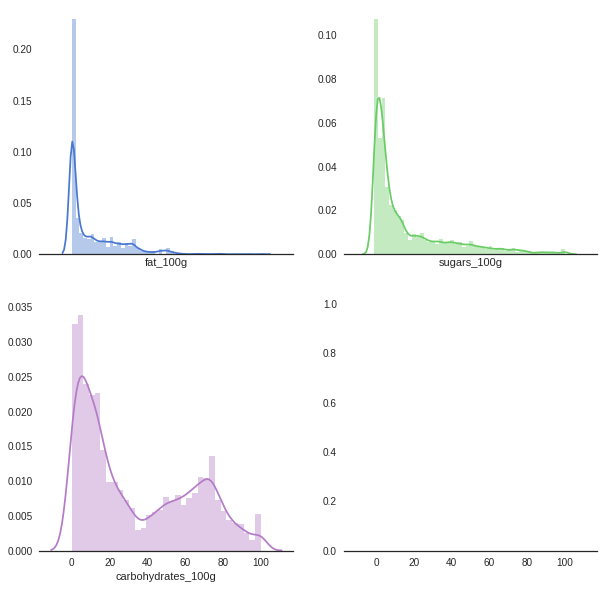

In [0]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(df.fat_100g, color="b", ax=axes[0, 0])
sns.distplot(df.sugars_100g, color="g", ax=axes[0, 1])
sns.distplot(df.carbohydrates_100g, color="m", ax=axes[1, 0])

### Word Cloud

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#### High fat and sugar foods

Find fatty and sweet foods in the 99th percentile

In [0]:
high_fat_df = df[df.fat_100g > df.fat_100g.quantile(.99)]
high_sugar_df = df[df.sugars_100g > df.sugars_100g.quantile(.99)]
high_carbohydrates_df = df[df.carbohydrates_100g > df.carbohydrates_100g.quantile(.99)]
high_fat_and_sugar_df = high_fat_df.append(pd.DataFrame(data = high_sugar_df), ignore_index=True)
high_fat_and_sugar_df = high_fat_df.append(pd.DataFrame(data = high_carbohydrates_df), ignore_index=True)

In [0]:
high_fat_and_sugar_text = high_fat_and_sugar_df['product'].values
len(high_fat_and_sugar_text)

448

Word Cloud High Fat and sugar

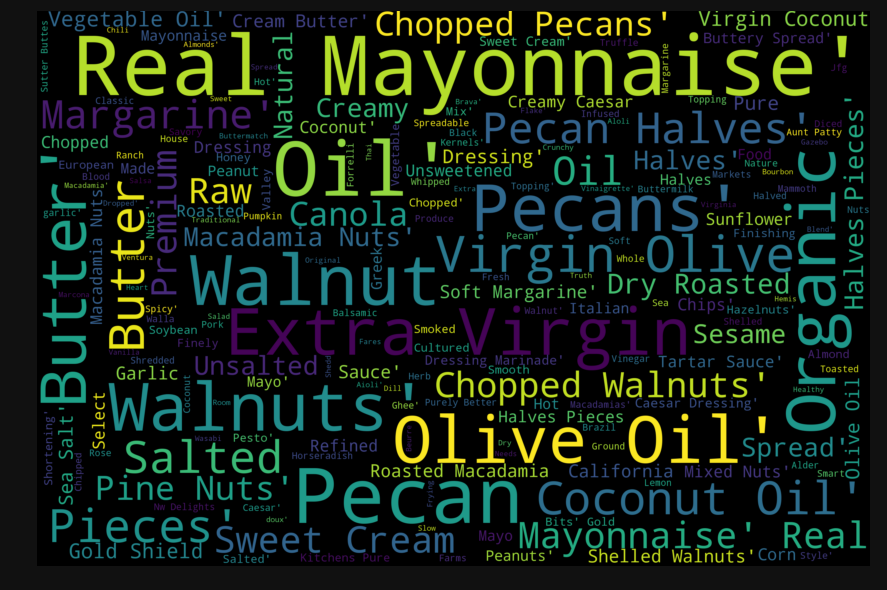

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(high_fat_and_sugar_text))

fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Modeling

### Create Features to Cluster

In [0]:
df.columns

Index(['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
       'salt_100g', 'energy_100g', 'product'],
      dtype='object')

We will cluster based on fat, carbohydrates, and sugars.

In [0]:
df_cluster_features = df.drop(['proteins_100g',
       'salt_100g', 'energy_100g','product'], axis=1)

In [0]:
df_cluster_features.describe()

,fat_100g,carbohydrates_100g,sugars_100g
count,45026.000000,45026.000000,45026.000000
mean,10.765991,34.054064,16.005077
std,14.930295,29.557393,21.495731
min,0.000000,0.000000,-1.200000
25%,0.000000,7.440000,1.570000
50%,3.170000,22.390000,5.880000
75%,17.860000,61.540000,23.080000
max,100.000000,100.000000,100.000000


### Scale the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(df_cluster_features))
print(scaler.transform(df_cluster_features))

MinMaxScaler(copy=True, feature_range=(0, 1))
[[0.2857     0.6429     0.15306324]
 [0.5714     0.1786     0.04713439]
 [0.1875     0.5781     0.16620553]
 ...
 [0.         0.1333     0.14357708]
 [0.         0.1625     0.17243083]
 [0.         0.         0.01185771]]


### Determine Cluster Number

#### Yellowbrick Visualizer Elbow Method

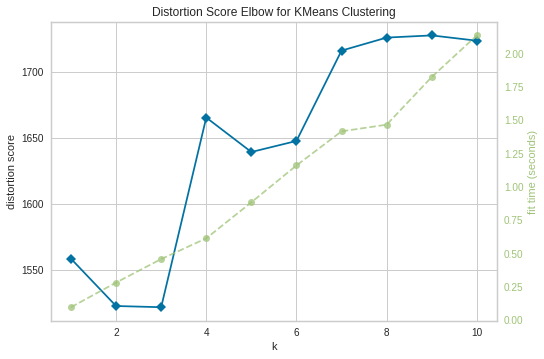

In [0]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))

visualizer.fit(df_cluster_features)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

**Two clusters seem ideal (healthy and unhealthy food).**

#### Yellowbrick Silhouette Visualizer


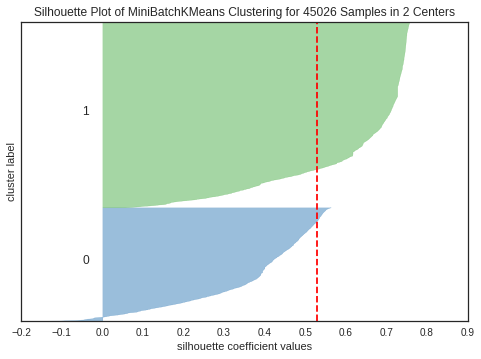

In [0]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(2)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df_cluster_features) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### Clustering

In [0]:
new_df = df.drop(['proteins_100g','salt_100g', 'energy_100g'], axis=1)

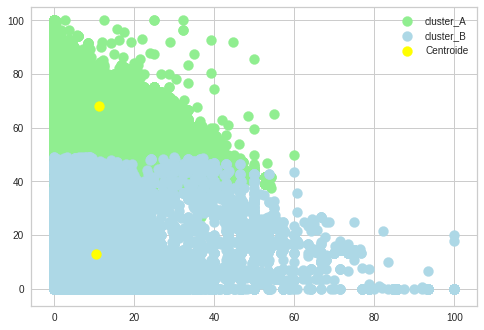

In [0]:
X = new_df.iloc[:, [0, 1, 2]].values
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'lightgreen', label = 'cluster_A')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'lightblue', label = 'cluster_B')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroide')

plt.legend()

In [0]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=2)
kmeans = k_means.fit(scaler.transform(df_cluster_features))

In [0]:
new_df['cluster'] = kmeans.labels_
new_df.head(10)

,fat_100g,carbohydrates_100g,sugars_100g,product,cluster
0,28.57,64.29,14.29,Banana Chips Sweetened (Whole),1
2,57.14,17.86,3.57,Organic Salted Nut Mix,0
3,18.75,57.81,15.62,Organic Muesli,1
4,36.67,36.67,3.33,Zen Party Mix,0
5,18.18,60.00,21.82,Cinnamon Nut Granola,1
6,60.71,17.86,3.57,Organic Hazelnuts,0
7,5.95,66.67,2.38,Organic Oat Groats,1
8,17.50,42.50,32.50,Energy Power Mix,1
9,33.33,46.67,30.00,Antioxidant Mix - Berries & Chocolate,1
10,10.91,69.09,27.27,Organic Quinoa Coconut Granola With Mango,1


**Examine what does cluster 1 and clsuter 0 represent**

In [0]:
new_df.sort_values(by=["sugars_100g","carbohydrates_100g","fat_100g"], ascending=[True, True, True]).head()

,fat_100g,carbohydrates_100g,sugars_100g,product,cluster
7612,0.0,3.61,-1.2,Grade A Fancy Chopped Spinach,0
16295,0.8,7.20,-0.8,"Select, Spicy Red Bell Pepper Pasta Sauce",0
99,0.0,0.00,0.0,Naturally Flavored Beverage Enhancer With Othe...,0
235,0.0,0.00,0.0,Raw Shrimp,0
240,0.0,0.00,0.0,"Augason Farms, Vital Wheat Gluten",0


In [0]:
new_df.sort_values(by=["sugars_100g","carbohydrates_100g","fat_100g"], ascending=[False, False, False]).head()

,fat_100g,carbohydrates_100g,sugars_100g,product,cluster
8254,25.0,100.0,100.0,Princess Mix Decorations,1
8255,25.0,100.0,100.0,Frosted Mix,1
8253,12.5,100.0,100.0,Holiday Happiness Mix,1
222,0.0,100.0,100.0,Tnt Exploding Candy,1
223,0.0,100.0,100.0,Exploding Candy,1


## Conclusion



*   What we want to achieve from the dataset determines how to choose appropriate features. This notebook is to target Hyperglycemic patients and to help them prevent or reduce the intake of high-carbohydrate and high-fat food. Therefore, choosing fat, carbohydrates, and sugars as the clustering features is more reasonable.
*   Using the clustering results, Hyperglycemic patients can look in the clustered data frame and have a basic idea of whether the chosen food is good for them or not.

